In [1]:
from rdkit import Chem
import pickle
import numpy as np
import pandas as pd
from IPython.display import display
from copy import deepcopy

# Load processed data

In [2]:
dataset = pd.read_csv("/home/abhor/Desktop/datasets/my_uspto/processed_data.csv", index_col=0)

In [3]:
dataset

,reactants,reagents,products
0,CON(C)C(=O)c1ccc(O)nc1,C1CCOC1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1
1,O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,O,CNc1ccc(C(=O)O)cc1[N+](=O)[O-]
2,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21
3,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)O)c1,CC(C)=C(Cl)N(C)C.ClCCl.c1ccncc1,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...
4,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1,NaN,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1
...,...,...,...
448504,CCP(CC)CC,NaN,CCCCOS(=O)(=O)[O-]
448505,CCCCOS(=O)(=O)OCCCC,NaN,CCCC[P+](CC)(CC)CC
448506,Cc1cccc(C)c1N=C1NCCN1OCc1ccccn1,CC#N.Cl,Cc1cccc(C)c1N=C1NCCN1O
448507,Clc1ccnc(Cl)c1,ClCCl,N[n+]1ccc(Cl)cc1Cl


# Reaction signature

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem import rdchem

In [14]:
mol1 = Chem.MolFromSmiles(dataset["reactants"][0])
mol2 = Chem.MolFromSmiles(dataset["products"][0])

In [6]:
def get_connecting_atoms(mol, subgraph):
    '''
    Finds pair of atoms that connect 'mol' to 'subgraph'
    mol: Complete molecule
    subgraph: Part of mol (reaction signatire)
    
    Returns:
        [(A1, A2), (A1', A2'), ...]
        Where each tuple is a connected pair of atom such that A1 \in subgraph, A2 \in (mol-subgraph)
    '''
    # get subgraph matches
    matches = np.array(rdchem.Mol(mol).GetSubstructMatches(subgraph))
    connections = []
    for match in matches:
        # atoms in connected subgraph
        atoms = [mol.GetAtomWithIdx(int(match[i])) for i in range(len(match))]
        for atom in atoms:
            # for each atom in connected subgraph, get neighbors
            neighbors = atom.GetNeighbors()
            neighbor_idx = set([n.GetIdx() for n in neighbors])
            # if there is a neighbor in (mol - subgraph), add connection to 
            if (neighbor_idx - set(match)):
                if len(neighbor_idx - set(match)) == 1:
                    connections.append((atom.GetIdx(), (neighbor_idx - set(match)).pop()))

    # remove repetitions
    connections = list(set(connections))
    return connections

def connect_substructures_if_applicable(mol, connections, add_prev_atom=True):
    '''
    If multiple connections have an atom in common, combine the substructures with the connection atom.
    Also, if requested, add the connecting atom to the substructure to maintain uniformity.
    mol: Molecule
    connections: (same as return of get_connecting_atoms)
    add_prev_atom: bool
            Add one connecting atom to the substructure.
    
    Returns:
        connections with substructures combined (same format as input connections)
    '''
    # combine if two connections have common atom in substructure
    d = {conn[1]: [] for conn in connections}
    for conn in connections:
        d[conn[1]].append(conn)
    connections = []
    for key in d:
        # combine
        atom = mol.GetAtomWithIdx(key)
        neighbors = atom.GetNeighbors()
        # get neighbors not in previous connections
        neighbor_idx = set([n.GetIdx() for n in neighbors]) - set([n[0] for n in d[key]])
        if len(neighbor_idx) == 1 and add_prev_atom:
            for idx in neighbor_idx:
                connections.append((key, idx))
        else:
            # let it be
            connections.extend(d[key])
    return connections

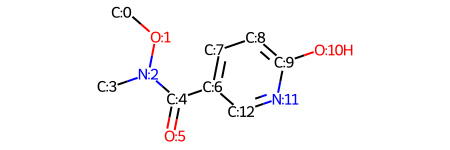

In [7]:
# draw molecule with index
def mol_with_atom_index( mol ):
    mol = deepcopy(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol
mol_with_atom_index(mol1)

Common substructure


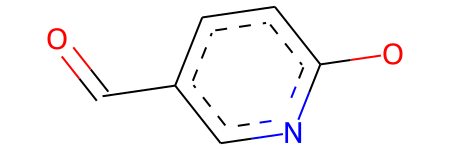

mol1 - common


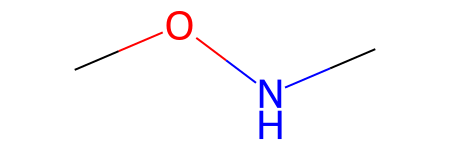

mol2 - common


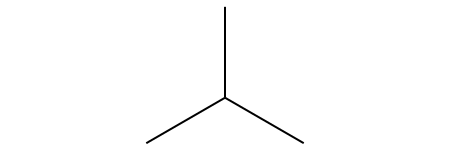

(<rdkit.Chem.rdchem.Mol at 0x7f1e94f07f30>,
 <rdkit.Chem.rdchem.Mol at 0x7f1e94f08c60>)

In [8]:
def get_substructures(mol1, mol2, disp=False):
    '''
    Takes 2 molecules. 
    Returns (common_substructure, reac_sig1, reac_sig2)
    '''
    # find common substruction (to later substract)
    res=rdFMCS.FindMCS([mol1, mol2])
    common_substructure = Chem.MolFromSmarts(res.smartsString)
    if disp: 
        print("Common substructure")
        display(common_substructure)

    # reaction signature in mol 1
    mol1_diff = AllChem.DeleteSubstructs(mol1, common_substructure)
    if disp: 
        print("mol1 - common")
        display(mol1_diff)

    # reaction signature in mol 2
    mol2_diff = AllChem.DeleteSubstructs(mol2, common_substructure)
    if disp: 
        print("mol2 - common")
        display(mol2_diff)
    
    return common_substructure, mol1_diff, mol2_diff
    
get_substructures(mol1, mol2, disp=True)

In [9]:
def disconnect_and_get_signature(mol, connections, subgraphs):
    '''
    Disconnects the bonds in "connections" from "mol" 
    and returns (a list of) the disconnected part that contains all the "subgraphs"
    '''
    # convert single mol of disconnected subgraphs to a list of connected subgraphs
    if Chem.MolToSmiles(subgraphs) == '':
        return []
    subgraphs = [Chem.MolFromSmiles(s) for s in Chem.MolToSmiles(subgraphs).split(".")]
    
    mol = rdchem.EditableMol(mol)
    # disconnect
    for conn in connections:
        mol.RemoveBond(conn[0], conn[1])
    mol = mol.GetMol()
    
    # extract the part that has "subgraphs"
    smile_list = Chem.MolToSmiles(mol).split(".")
    # sorting acc to size for better chances less chances of problems
    smile_list = [s for _, s in sorted(zip(list(map(len, smile_list)), smile_list))]
    signature = ''
    for smile in smile_list:
        temp_mol = Chem.MolFromSmiles(smile)
        # case 0: No additional subgraph
        assert len(smile_list) > 1, "Found no subgraphs in molecule"

        # case 1: There's only 1 additional subgraph
        if len(smile_list) == 2:
            if all([temp_mol.HasSubstructMatch(sub) for sub in subgraphs]):
                return [temp_mol]
            
        # case 2: There is more than 1 additional subgraph
        else:
            # try to find the subgraph that doesn't contain any "subgraphs" and return the others
            if not any(([temp_mol.HasSubstructMatch(sub) for sub in subgraphs])):
                return [Chem.MolFromSmiles(s) for s in list(filter(lambda x: x!=smile), smile_list)]
            
    # return the subgraphs with the smallest number of nodes (expectation: subgraphs are smaller than core)
    smile_list = smile_list.pop(np.argmax(list(map(len, smile_list))))
    return [Chem.MolFromSmiles(s) for s in smile_list]

In [10]:
def get_reaction_signatures(i, disp=False):
    mol1 = Chem.MolFromSmiles(dataset["reactants"][i])
    mol2 = Chem.MolFromSmiles(dataset["products"][i])

    # display raw mols
    if disp:
        print("Mol1")
        display(mol1)

        print("Mol2")
        display(mol2)

    # get initial (unprocessed) reaction signatures
    common_substructure, mol1_diff, mol2_diff = get_substructures(mol1, mol2, disp=disp)
    print(Chem.MolToSmiles(mol1_diff))
    print(Chem.MolToSmiles(mol2_diff))

    if disp:
        print("-"*100)

    # display with indices
    if disp: 
        print("With indices - mol1, mol2 and common")
        display(mol_with_atom_index(mol1))
        display(mol_with_atom_index(mol2))
        display(mol_with_atom_index(common_substructure))

    if disp:
        print("-"*100)

    # mapping of molecule idx to common_substructure idx
    mol1_to_com_map = np.array(rdchem.Mol(mol1).GetSubstructMatch(common_substructure))
    mol2_to_com_map = np.array(rdchem.Mol(mol2).GetSubstructMatch(common_substructure))

    def comm_idx1(idx):
        '''
        return the atom idx in comm_sub corresponding to 'idx' in mol1
        '''
        arr = abs(np.array(mol1_to_com_map) - idx)
        if 0 not in arr:
            return -1
        return arr.argmin()

    def comm_idx2(idx):
        '''
        return the atom idx in comm_sub corresponding to 'idx' in mol2
        '''
        arr = abs(np.array(mol2_to_com_map) - idx)
        if 0 not in arr:
            return -1
        return arr.argmin()


    com_to_mol1_map = list(map(comm_idx1, mol1_to_com_map))
    com_to_mol2_map = list(map(comm_idx2, mol2_to_com_map))

    if disp:
        print("mol1_to_com_map", mol1_to_com_map)
        print("mol2_to_com_map", mol2_to_com_map)
        print("com_to_mol1_map", com_to_mol1_map)
        print("com_to_mol2_map", com_to_mol2_map)

    # get connection points
    con1 = get_connecting_atoms(mol1, mol1_diff)
    con2 = get_connecting_atoms(mol2, mol2_diff)

    con1 = list(filter(lambda x: (comm_idx1(x[1]) in com_to_mol1_map) and \
                                   (comm_idx1(x[0]) not in com_to_mol1_map), con1))
    con2 = list(filter(lambda x: (comm_idx2(x[1]) in com_to_mol2_map) and \
                                   (comm_idx2(x[0]) not in com_to_mol2_map), con2))
    
    con1, con2 = connect_substructures_if_applicable(mol1, con1, not (Chem.MolToSmiles(mol2_diff) == '')), \
                connect_substructures_if_applicable(mol2, con2, not (Chem.MolToSmiles(mol1_diff) == ''))
    
    if disp:
        print("Con1", con1)
        print("Con2", con2)
        if con1 and con2:
            print("Common idx for connection:", comm_idx1(con1[0][1]), comm_idx2(con2[0][1]))

    # verification
    assert (len(con1) <= 1 and len(con2) <= 1) or (len(con1) == len(con2)), f"{len(con1)} vs {len(con2)}"
    
    # get final reaction signatures
    sig1 = disconnect_and_get_signature(mol1, con1, mol1_diff)
    sig2 = disconnect_and_get_signature(mol2, con2, mol2_diff)
    
    return mol1, mol2, sig1, sig2

In [44]:
from rdkit.Chem.Draw import rdMolDraw2D

def draw_mol_with_highlight(mol, hit_ats):
    '''
    Highlight the atoms in mol that have index in 'hit_ats'
    '''
    hit_ats = list(set(hit_ats))
    print(hit_ats)
#     # this is the code given in rdkit docs but doesn't actually work
#     d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
#     rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,)
    mol1.__sssAtoms = hit_ats # workaround for now. Might not work in a later version of rdkit
    display(mol_with_atom_index(mol))

def highlight_signatures(mol1, mol2, sig1, sig2):
    # get common substructure and mapping of atom indices
    common_substructure, _, __ = get_substructures(mol1, mol2, disp=False)
    mol1_to_com_map = np.array(rdchem.Mol(mol1).GetSubstructMatch(common_substructure))
    mol2_to_com_map = np.array(rdchem.Mol(mol2).GetSubstructMatch(common_substructure))
    
    hit_ats1 = []
    hit_ats2 = []

    # get atoms to highlight for mol1
    for sig in sig1:
        matches = rdchem.Mol(mol1).GetSubstructMatches(sig)
        filterer = list(map(lambda x: list(set(x) - set(mol1_to_com_map)), matches))
        for i in range(len(matches)):
            if filterer[i] != []:
                hit_ats1.extend(matches[i])
        
    # get atoms to highlight for mol2
    for sig in sig2:
        matches = rdchem.Mol(mol2).GetSubstructMatches(sig)
        filterer = list(map(lambda x: list(set(x) - set(mol2_to_com_map)), matches))
        for i in range(len(matches)):
            if filterer[i] != []:
                hit_ats2.extend(matches[i])
    draw_mol_with_highlight(mol1, hit_ats1)
    draw_mol_with_highlight(mol2, hit_ats2)

CNOC
CC(C)C
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
[0, 1, 2, 3, 4]


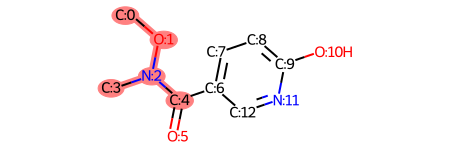

NOTE: The highlight may not be accurate. As long as the subgroup is fine, just roll with it.
[0, 1, 2, 3]


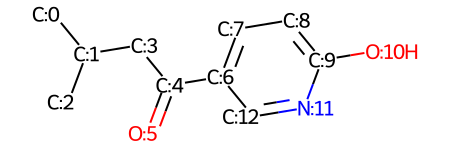

NOTE: The highlight may not be accurate. As long as the subgroup is fine, just roll with it.


In [43]:
i = 0
mol1, mol2, sig1, sig2 = get_reaction_signatures(i, False)

print("-"*100)
print("-"*100)
highlight_signatures(mol1, mol2, sig1, sig2)

import time
for i in range(0, 1000):
    if i not in special_cases:
        try:
            t = time.time()
            get_reaction_signatures(i)
            print(i, time.time() - t)
        except Exception as e:
            try:
                print(i)
                get_reaction_signatures(i, disp=True)
                print("\n\n")
            except Exception as e:
                print(e)

special_cases = [42, 64, 74, 113, 170, 193, 225, 487]
special_cases = [487]